In [2]:
import xgboost as xgb
#import lightgbm as lgb
import catboost as cat

In [3]:
import pandas as pd
import joblib

In [4]:
import numpy as np
import random

In [5]:
np.random.seed(42)
random.seed(42)

In [6]:
def read_merge_data(data_type="training"):
    #
    Dfs = []
    train_df = []
    train_output = pd.read_csv("./data_phase_one/training_output.csv", header=None)
    coords = pd.read_csv("data_phase_one/coords.csv", header=None)
    for name in ["mslp", "sst", "ssta", "t2m"]:
        df = pd.read_csv(f"./data_phase_one/{data_type}_input_{name}.csv", header=None)
        print("Shape df", df.shape)
        Dfs.append(df)
    j = 0
    for i in range(0, df.shape[0]-12, 1):
        feat = pd.concat([coords, Dfs[0].iloc[i:i+12], Dfs[1].iloc[i:i+12], Dfs[2].iloc[i:i+12], Dfs[3].iloc[i:i+12]], axis=0).reset_index(drop=True)
        tgt = train_output.iloc[i+11]
        tgt = tgt.T.reset_index(drop=True)
        feat = feat.T.reset_index(drop=True)
        feat = pd.concat([feat, tgt], axis=1)
        assert feat.shape[1]==51
        feat.columns = [f"feat_{k}" for k in range(feat.shape[1]-1)] + ["target"]
        if j < 3:
            print(feat.columns)
        train_df.append(feat)
        j += 1
    train_df = pd.concat(train_df, axis=0)
    #Dfs.index = [f"col_{i}" for i in range(848)]
    return train_df

In [7]:
data = read_merge_data()

Shape df (849, 5774)
Shape df (849, 5774)
Shape df (849, 5774)
Shape df (849, 5774)
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24',
       'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30',
       'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36',
       'feat_37', 'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42',
       'feat_43', 'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48',
       'feat_49', 'target'],
      dtype='object')
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23'

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [9]:
cv = KFold(n_splits=5, shuffle=True)

In [10]:
params_xgb = {
    "booster": "gbtree",
    "max_depth": 8,
    "learning_rate": 0.01,
    "n_estimators": 2000,
    #"colsample_bytree": 0.8, 
    #"colsample_bynode": 0.8,
    "verbose": -1,
    "predictor": "gpu_predictor"}

In [17]:
params_catb = dict(
task_type="CPU",
devices='1',
reg_lambda=0.438, learning_rate=0.1,
max_depth=8, min_data_in_leaf=50,
n_estimators=2000, verbose=50,
objective='RMSE')

In [ ]:
params_lgb = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "max_depth": 8,
    'num_leaves': 255,
    "learning_rate": 0.01,
    "n_estimators": 2000,
    #"colsample_bytree": 0.8, 
    #"colsample_bynode": 0.8,
    "verbose": -1,
    "device": "gpu",
    "gpu_device_id": 1}

In [16]:
for state, (train_idx, val_idx) in enumerate(cv.split(data)):
    X_train = data.drop(columns=["target"]).iloc[train_idx].values
    X_val = data.drop(columns=["target"]).iloc[val_idx].values
    y_train = data["target"].iloc[train_idx].values
    y_val = data["target"].iloc[val_idx].values
    print(f"\nTrain: {len(y_train)}, Val: {len(y_val)}\n")
    xgb_model = xgb.XGBRegressor(**params_xgb, random_state=state)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)])
    joblib.dump(xgb_model, f"./kfold_trained/xgb_model_fold{state}.joblib")


Train: 3866270, Val: 966568



/home/arnab/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:11:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:0.61501
[1]	validation_0-rmse:0.61357
[2]	validation_0-rmse:0.61215
[3]	validation_0-rmse:0.61076
[4]	validation_0-rmse:0.60938
[5]	validation_0-rmse:0.60804
[6]	validation_0-rmse:0.60671
[7]	validation_0-rmse:0.60541
[8]	validation_0-rmse:0.60413
[9]	validation_0-rmse:0.60287
[10]	validation_0-rmse:0.60163
[11]	validation_0-rmse:0.60042
[12]	validation_0-rmse:0.59922
[13]	validation_0-rmse:0.59804
[14]	validation_0-rmse:0.59689
[15]	validation_0-rmse:0.59575
[16]	validation_0-rmse:0.59463
[17]	validation_0-rmse:0.59354
[18]	validation_0-rmse:0.59245
[19]	validation_0-rmse:0.59139
[20]	validation_0-rmse:0.59035
[21]	validation_0-rmse:0.58932
[22]	validation_0-rmse:0.58831
[23]	validation_0-rmse:0.58732
[24]	validation_0-rmse:0.58634
[25]	validation_0-rmse:0.58538
[26]	validation_0-rmse:0.58443
[27]	validation_0-rmse:0.58350
[28]	validation_0-rmse:0.58259
[29]	validation_0-rmse:0.58169
[30]	validation_0-rmse:0.58081
[31]	validation_0-rmse:0.57994
[32]	validation_0-

[260]	validation_0-rmse:0.52734
[261]	validation_0-rmse:0.52730
[262]	validation_0-rmse:0.52726
[263]	validation_0-rmse:0.52721
[264]	validation_0-rmse:0.52717
[265]	validation_0-rmse:0.52713
[266]	validation_0-rmse:0.52709
[267]	validation_0-rmse:0.52705
[268]	validation_0-rmse:0.52701
[269]	validation_0-rmse:0.52697
[270]	validation_0-rmse:0.52694
[271]	validation_0-rmse:0.52690
[272]	validation_0-rmse:0.52686
[273]	validation_0-rmse:0.52682
[274]	validation_0-rmse:0.52677
[275]	validation_0-rmse:0.52674
[276]	validation_0-rmse:0.52670
[277]	validation_0-rmse:0.52666
[278]	validation_0-rmse:0.52663
[279]	validation_0-rmse:0.52659
[280]	validation_0-rmse:0.52656
[281]	validation_0-rmse:0.52652
[282]	validation_0-rmse:0.52649
[283]	validation_0-rmse:0.52645
[284]	validation_0-rmse:0.52642
[285]	validation_0-rmse:0.52639
[286]	validation_0-rmse:0.52635
[287]	validation_0-rmse:0.52631
[288]	validation_0-rmse:0.52628
[289]	validation_0-rmse:0.52624
[290]	validation_0-rmse:0.52621
[291]	va

[517]	validation_0-rmse:0.52034
[518]	validation_0-rmse:0.52032
[519]	validation_0-rmse:0.52030
[520]	validation_0-rmse:0.52027
[521]	validation_0-rmse:0.52026
[522]	validation_0-rmse:0.52023
[523]	validation_0-rmse:0.52022
[524]	validation_0-rmse:0.52019
[525]	validation_0-rmse:0.52017
[526]	validation_0-rmse:0.52016
[527]	validation_0-rmse:0.52013
[528]	validation_0-rmse:0.52011
[529]	validation_0-rmse:0.52010
[530]	validation_0-rmse:0.52008
[531]	validation_0-rmse:0.52006
[532]	validation_0-rmse:0.52005
[533]	validation_0-rmse:0.52003
[534]	validation_0-rmse:0.52001
[535]	validation_0-rmse:0.51999
[536]	validation_0-rmse:0.51997
[537]	validation_0-rmse:0.51995
[538]	validation_0-rmse:0.51993
[539]	validation_0-rmse:0.51991
[540]	validation_0-rmse:0.51990
[541]	validation_0-rmse:0.51988
[542]	validation_0-rmse:0.51986
[543]	validation_0-rmse:0.51984
[544]	validation_0-rmse:0.51982
[545]	validation_0-rmse:0.51980
[546]	validation_0-rmse:0.51978
[547]	validation_0-rmse:0.51976
[548]	va

[774]	validation_0-rmse:0.51679
[775]	validation_0-rmse:0.51678
[776]	validation_0-rmse:0.51676
[777]	validation_0-rmse:0.51675
[778]	validation_0-rmse:0.51674
[779]	validation_0-rmse:0.51673
[780]	validation_0-rmse:0.51673
[781]	validation_0-rmse:0.51671
[782]	validation_0-rmse:0.51671
[783]	validation_0-rmse:0.51670
[784]	validation_0-rmse:0.51669
[785]	validation_0-rmse:0.51668
[786]	validation_0-rmse:0.51668
[787]	validation_0-rmse:0.51666
[788]	validation_0-rmse:0.51665
[789]	validation_0-rmse:0.51663
[790]	validation_0-rmse:0.51663
[791]	validation_0-rmse:0.51662
[792]	validation_0-rmse:0.51661
[793]	validation_0-rmse:0.51659
[794]	validation_0-rmse:0.51658
[795]	validation_0-rmse:0.51657
[796]	validation_0-rmse:0.51656
[797]	validation_0-rmse:0.51655
[798]	validation_0-rmse:0.51654
[799]	validation_0-rmse:0.51654
[800]	validation_0-rmse:0.51652
[801]	validation_0-rmse:0.51651
[802]	validation_0-rmse:0.51650
[803]	validation_0-rmse:0.51649
[804]	validation_0-rmse:0.51648
[805]	va

[1030]	validation_0-rmse:0.51433
[1031]	validation_0-rmse:0.51432
[1032]	validation_0-rmse:0.51432
[1033]	validation_0-rmse:0.51431
[1034]	validation_0-rmse:0.51430
[1035]	validation_0-rmse:0.51430
[1036]	validation_0-rmse:0.51429
[1037]	validation_0-rmse:0.51428
[1038]	validation_0-rmse:0.51428
[1039]	validation_0-rmse:0.51427
[1040]	validation_0-rmse:0.51426
[1041]	validation_0-rmse:0.51426
[1042]	validation_0-rmse:0.51425
[1043]	validation_0-rmse:0.51424
[1044]	validation_0-rmse:0.51423
[1045]	validation_0-rmse:0.51423
[1046]	validation_0-rmse:0.51422
[1047]	validation_0-rmse:0.51422
[1048]	validation_0-rmse:0.51421
[1049]	validation_0-rmse:0.51420
[1050]	validation_0-rmse:0.51420
[1051]	validation_0-rmse:0.51419
[1052]	validation_0-rmse:0.51419
[1053]	validation_0-rmse:0.51417
[1054]	validation_0-rmse:0.51417
[1055]	validation_0-rmse:0.51415
[1056]	validation_0-rmse:0.51414
[1057]	validation_0-rmse:0.51414
[1058]	validation_0-rmse:0.51413
[1059]	validation_0-rmse:0.51412
[1060]	val

[1279]	validation_0-rmse:0.51248
[1280]	validation_0-rmse:0.51248
[1281]	validation_0-rmse:0.51247
[1282]	validation_0-rmse:0.51246
[1283]	validation_0-rmse:0.51245
[1284]	validation_0-rmse:0.51244
[1285]	validation_0-rmse:0.51244
[1286]	validation_0-rmse:0.51243
[1287]	validation_0-rmse:0.51242
[1288]	validation_0-rmse:0.51241
[1289]	validation_0-rmse:0.51241
[1290]	validation_0-rmse:0.51240
[1291]	validation_0-rmse:0.51240
[1292]	validation_0-rmse:0.51239
[1293]	validation_0-rmse:0.51238
[1294]	validation_0-rmse:0.51237
[1295]	validation_0-rmse:0.51237
[1296]	validation_0-rmse:0.51236
[1297]	validation_0-rmse:0.51236
[1298]	validation_0-rmse:0.51235
[1299]	validation_0-rmse:0.51234
[1300]	validation_0-rmse:0.51234
[1301]	validation_0-rmse:0.51233
[1302]	validation_0-rmse:0.51232
[1303]	validation_0-rmse:0.51232
[1304]	validation_0-rmse:0.51231
[1305]	validation_0-rmse:0.51231
[1306]	validation_0-rmse:0.51230
[1307]	validation_0-rmse:0.51229
[1308]	validation_0-rmse:0.51228
[1309]	val

[1528]	validation_0-rmse:0.51075
[1529]	validation_0-rmse:0.51075
[1530]	validation_0-rmse:0.51074
[1531]	validation_0-rmse:0.51073
[1532]	validation_0-rmse:0.51073
[1533]	validation_0-rmse:0.51072
[1534]	validation_0-rmse:0.51071
[1535]	validation_0-rmse:0.51070
[1536]	validation_0-rmse:0.51069
[1537]	validation_0-rmse:0.51068
[1538]	validation_0-rmse:0.51067
[1539]	validation_0-rmse:0.51066
[1540]	validation_0-rmse:0.51066
[1541]	validation_0-rmse:0.51065
[1542]	validation_0-rmse:0.51064
[1543]	validation_0-rmse:0.51063
[1544]	validation_0-rmse:0.51062
[1545]	validation_0-rmse:0.51061
[1546]	validation_0-rmse:0.51060
[1547]	validation_0-rmse:0.51059
[1548]	validation_0-rmse:0.51058
[1549]	validation_0-rmse:0.51057
[1550]	validation_0-rmse:0.51056
[1551]	validation_0-rmse:0.51056
[1552]	validation_0-rmse:0.51056
[1553]	validation_0-rmse:0.51055
[1554]	validation_0-rmse:0.51054
[1555]	validation_0-rmse:0.51053
[1556]	validation_0-rmse:0.51052
[1557]	validation_0-rmse:0.51052
[1558]	val

[1777]	validation_0-rmse:0.50909
[1778]	validation_0-rmse:0.50908
[1779]	validation_0-rmse:0.50907
[1780]	validation_0-rmse:0.50907
[1781]	validation_0-rmse:0.50906
[1782]	validation_0-rmse:0.50906
[1783]	validation_0-rmse:0.50906
[1784]	validation_0-rmse:0.50905
[1785]	validation_0-rmse:0.50904
[1786]	validation_0-rmse:0.50904
[1787]	validation_0-rmse:0.50904
[1788]	validation_0-rmse:0.50903
[1789]	validation_0-rmse:0.50903
[1790]	validation_0-rmse:0.50902
[1791]	validation_0-rmse:0.50902
[1792]	validation_0-rmse:0.50901
[1793]	validation_0-rmse:0.50900
[1794]	validation_0-rmse:0.50899
[1795]	validation_0-rmse:0.50898
[1796]	validation_0-rmse:0.50897
[1797]	validation_0-rmse:0.50897
[1798]	validation_0-rmse:0.50897
[1799]	validation_0-rmse:0.50896
[1800]	validation_0-rmse:0.50896
[1801]	validation_0-rmse:0.50895
[1802]	validation_0-rmse:0.50894
[1803]	validation_0-rmse:0.50894
[1804]	validation_0-rmse:0.50893
[1805]	validation_0-rmse:0.50893
[1806]	validation_0-rmse:0.50892
[1807]	val

/home/arnab/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:25:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:0.61558
[1]	validation_0-rmse:0.61414
[2]	validation_0-rmse:0.61272
[3]	validation_0-rmse:0.61132
[4]	validation_0-rmse:0.60994
[5]	validation_0-rmse:0.60859
[6]	validation_0-rmse:0.60726
[7]	validation_0-rmse:0.60596
[8]	validation_0-rmse:0.60468
[9]	validation_0-rmse:0.60341
[10]	validation_0-rmse:0.60217
[11]	validation_0-rmse:0.60095
[12]	validation_0-rmse:0.59975
[13]	validation_0-rmse:0.59857
[14]	validation_0-rmse:0.59741
[15]	validation_0-rmse:0.59627
[16]	validation_0-rmse:0.59515
[17]	validation_0-rmse:0.59404
[18]	validation_0-rmse:0.59296
[19]	validation_0-rmse:0.59189
[20]	validation_0-rmse:0.59085
[21]	validation_0-rmse:0.58981
[22]	validation_0-rmse:0.58880
[23]	validation_0-rmse:0.58780
[24]	validation_0-rmse:0.58682
[25]	validation_0-rmse:0.58586
[26]	validation_0-rmse:0.58491
[27]	validation_0-rmse:0.58398
[28]	validation_0-rmse:0.58306
[29]	validation_0-rmse:0.58216
[30]	validation_0-rmse:0.58128
[31]	validation_0-rmse:0.58041
[32]	validation_0-

[260]	validation_0-rmse:0.52771
[261]	validation_0-rmse:0.52766
[262]	validation_0-rmse:0.52762
[263]	validation_0-rmse:0.52758
[264]	validation_0-rmse:0.52754
[265]	validation_0-rmse:0.52750
[266]	validation_0-rmse:0.52746
[267]	validation_0-rmse:0.52742
[268]	validation_0-rmse:0.52737
[269]	validation_0-rmse:0.52733
[270]	validation_0-rmse:0.52730
[271]	validation_0-rmse:0.52726
[272]	validation_0-rmse:0.52722
[273]	validation_0-rmse:0.52718
[274]	validation_0-rmse:0.52714
[275]	validation_0-rmse:0.52710
[276]	validation_0-rmse:0.52707
[277]	validation_0-rmse:0.52703
[278]	validation_0-rmse:0.52700
[279]	validation_0-rmse:0.52696
[280]	validation_0-rmse:0.52692
[281]	validation_0-rmse:0.52687
[282]	validation_0-rmse:0.52684
[283]	validation_0-rmse:0.52680
[284]	validation_0-rmse:0.52676
[285]	validation_0-rmse:0.52672
[286]	validation_0-rmse:0.52669
[287]	validation_0-rmse:0.52665
[288]	validation_0-rmse:0.52662
[289]	validation_0-rmse:0.52658
[290]	validation_0-rmse:0.52655
[291]	va

[517]	validation_0-rmse:0.52072
[518]	validation_0-rmse:0.52069
[519]	validation_0-rmse:0.52068
[520]	validation_0-rmse:0.52066
[521]	validation_0-rmse:0.52064
[522]	validation_0-rmse:0.52062
[523]	validation_0-rmse:0.52060
[524]	validation_0-rmse:0.52059
[525]	validation_0-rmse:0.52057
[526]	validation_0-rmse:0.52055
[527]	validation_0-rmse:0.52053
[528]	validation_0-rmse:0.52051
[529]	validation_0-rmse:0.52049
[530]	validation_0-rmse:0.52047
[531]	validation_0-rmse:0.52046
[532]	validation_0-rmse:0.52044
[533]	validation_0-rmse:0.52042
[534]	validation_0-rmse:0.52040
[535]	validation_0-rmse:0.52039
[536]	validation_0-rmse:0.52037
[537]	validation_0-rmse:0.52035
[538]	validation_0-rmse:0.52033
[539]	validation_0-rmse:0.52032
[540]	validation_0-rmse:0.52030
[541]	validation_0-rmse:0.52028
[542]	validation_0-rmse:0.52026
[543]	validation_0-rmse:0.52024
[544]	validation_0-rmse:0.52022
[545]	validation_0-rmse:0.52020
[546]	validation_0-rmse:0.52018
[547]	validation_0-rmse:0.52016
[548]	va

[774]	validation_0-rmse:0.51712
[775]	validation_0-rmse:0.51711
[776]	validation_0-rmse:0.51710
[777]	validation_0-rmse:0.51708
[778]	validation_0-rmse:0.51708
[779]	validation_0-rmse:0.51707
[780]	validation_0-rmse:0.51705
[781]	validation_0-rmse:0.51704
[782]	validation_0-rmse:0.51703
[783]	validation_0-rmse:0.51702
[784]	validation_0-rmse:0.51701
[785]	validation_0-rmse:0.51700
[786]	validation_0-rmse:0.51699
[787]	validation_0-rmse:0.51698
[788]	validation_0-rmse:0.51698
[789]	validation_0-rmse:0.51697
[790]	validation_0-rmse:0.51696
[791]	validation_0-rmse:0.51695
[792]	validation_0-rmse:0.51694
[793]	validation_0-rmse:0.51694
[794]	validation_0-rmse:0.51693
[795]	validation_0-rmse:0.51692
[796]	validation_0-rmse:0.51691
[797]	validation_0-rmse:0.51690
[798]	validation_0-rmse:0.51689
[799]	validation_0-rmse:0.51688
[800]	validation_0-rmse:0.51687
[801]	validation_0-rmse:0.51686
[802]	validation_0-rmse:0.51685
[803]	validation_0-rmse:0.51683
[804]	validation_0-rmse:0.51682
[805]	va

[1030]	validation_0-rmse:0.51458
[1031]	validation_0-rmse:0.51457
[1032]	validation_0-rmse:0.51457
[1033]	validation_0-rmse:0.51456
[1034]	validation_0-rmse:0.51456
[1035]	validation_0-rmse:0.51455
[1036]	validation_0-rmse:0.51454
[1037]	validation_0-rmse:0.51453
[1038]	validation_0-rmse:0.51452
[1039]	validation_0-rmse:0.51451
[1040]	validation_0-rmse:0.51450
[1041]	validation_0-rmse:0.51449
[1042]	validation_0-rmse:0.51448
[1043]	validation_0-rmse:0.51447
[1044]	validation_0-rmse:0.51445
[1045]	validation_0-rmse:0.51445
[1046]	validation_0-rmse:0.51444
[1047]	validation_0-rmse:0.51443
[1048]	validation_0-rmse:0.51442
[1049]	validation_0-rmse:0.51442
[1050]	validation_0-rmse:0.51440
[1051]	validation_0-rmse:0.51440
[1052]	validation_0-rmse:0.51438
[1053]	validation_0-rmse:0.51437
[1054]	validation_0-rmse:0.51436
[1055]	validation_0-rmse:0.51435
[1056]	validation_0-rmse:0.51435
[1057]	validation_0-rmse:0.51434
[1058]	validation_0-rmse:0.51434
[1059]	validation_0-rmse:0.51432
[1060]	val

[1279]	validation_0-rmse:0.51266
[1280]	validation_0-rmse:0.51266
[1281]	validation_0-rmse:0.51265
[1282]	validation_0-rmse:0.51265
[1283]	validation_0-rmse:0.51265
[1284]	validation_0-rmse:0.51264
[1285]	validation_0-rmse:0.51263
[1286]	validation_0-rmse:0.51263
[1287]	validation_0-rmse:0.51262
[1288]	validation_0-rmse:0.51260
[1289]	validation_0-rmse:0.51259
[1290]	validation_0-rmse:0.51258
[1291]	validation_0-rmse:0.51257
[1292]	validation_0-rmse:0.51256
[1293]	validation_0-rmse:0.51255
[1294]	validation_0-rmse:0.51254
[1295]	validation_0-rmse:0.51253
[1296]	validation_0-rmse:0.51252
[1297]	validation_0-rmse:0.51251
[1298]	validation_0-rmse:0.51250
[1299]	validation_0-rmse:0.51249
[1300]	validation_0-rmse:0.51248
[1301]	validation_0-rmse:0.51248
[1302]	validation_0-rmse:0.51247
[1303]	validation_0-rmse:0.51247
[1304]	validation_0-rmse:0.51245
[1305]	validation_0-rmse:0.51245
[1306]	validation_0-rmse:0.51244
[1307]	validation_0-rmse:0.51244
[1308]	validation_0-rmse:0.51243
[1309]	val

[1528]	validation_0-rmse:0.51084
[1529]	validation_0-rmse:0.51084
[1530]	validation_0-rmse:0.51083
[1531]	validation_0-rmse:0.51082
[1532]	validation_0-rmse:0.51082
[1533]	validation_0-rmse:0.51081
[1534]	validation_0-rmse:0.51081
[1535]	validation_0-rmse:0.51080
[1536]	validation_0-rmse:0.51080
[1537]	validation_0-rmse:0.51079
[1538]	validation_0-rmse:0.51079
[1539]	validation_0-rmse:0.51078
[1540]	validation_0-rmse:0.51078
[1541]	validation_0-rmse:0.51077
[1542]	validation_0-rmse:0.51076
[1543]	validation_0-rmse:0.51076
[1544]	validation_0-rmse:0.51075
[1545]	validation_0-rmse:0.51074
[1546]	validation_0-rmse:0.51074
[1547]	validation_0-rmse:0.51073
[1548]	validation_0-rmse:0.51072
[1549]	validation_0-rmse:0.51071
[1550]	validation_0-rmse:0.51071
[1551]	validation_0-rmse:0.51071
[1552]	validation_0-rmse:0.51070
[1553]	validation_0-rmse:0.51070
[1554]	validation_0-rmse:0.51069
[1555]	validation_0-rmse:0.51068
[1556]	validation_0-rmse:0.51068
[1557]	validation_0-rmse:0.51066
[1558]	val

[1777]	validation_0-rmse:0.50925
[1778]	validation_0-rmse:0.50925
[1779]	validation_0-rmse:0.50924
[1780]	validation_0-rmse:0.50924
[1781]	validation_0-rmse:0.50923
[1782]	validation_0-rmse:0.50922
[1783]	validation_0-rmse:0.50921
[1784]	validation_0-rmse:0.50920
[1785]	validation_0-rmse:0.50919
[1786]	validation_0-rmse:0.50919
[1787]	validation_0-rmse:0.50918
[1788]	validation_0-rmse:0.50918
[1789]	validation_0-rmse:0.50917
[1790]	validation_0-rmse:0.50917
[1791]	validation_0-rmse:0.50917
[1792]	validation_0-rmse:0.50916
[1793]	validation_0-rmse:0.50916
[1794]	validation_0-rmse:0.50915
[1795]	validation_0-rmse:0.50915
[1796]	validation_0-rmse:0.50914
[1797]	validation_0-rmse:0.50914
[1798]	validation_0-rmse:0.50914
[1799]	validation_0-rmse:0.50913
[1800]	validation_0-rmse:0.50913
[1801]	validation_0-rmse:0.50912
[1802]	validation_0-rmse:0.50912
[1803]	validation_0-rmse:0.50911
[1804]	validation_0-rmse:0.50911
[1805]	validation_0-rmse:0.50909
[1806]	validation_0-rmse:0.50908
[1807]	val

/home/arnab/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:38:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:0.61528
[1]	validation_0-rmse:0.61383
[2]	validation_0-rmse:0.61240
[3]	validation_0-rmse:0.61100
[4]	validation_0-rmse:0.60962
[5]	validation_0-rmse:0.60826
[6]	validation_0-rmse:0.60693
[7]	validation_0-rmse:0.60562
[8]	validation_0-rmse:0.60433
[9]	validation_0-rmse:0.60307
[10]	validation_0-rmse:0.60183
[11]	validation_0-rmse:0.60060
[12]	validation_0-rmse:0.59940
[13]	validation_0-rmse:0.59821
[14]	validation_0-rmse:0.59705
[15]	validation_0-rmse:0.59590
[16]	validation_0-rmse:0.59478
[17]	validation_0-rmse:0.59367
[18]	validation_0-rmse:0.59259
[19]	validation_0-rmse:0.59151
[20]	validation_0-rmse:0.59047
[21]	validation_0-rmse:0.58943
[22]	validation_0-rmse:0.58842
[23]	validation_0-rmse:0.58742
[24]	validation_0-rmse:0.58644
[25]	validation_0-rmse:0.58548
[26]	validation_0-rmse:0.58453
[27]	validation_0-rmse:0.58360
[28]	validation_0-rmse:0.58269
[29]	validation_0-rmse:0.58179
[30]	validation_0-rmse:0.58090
[31]	validation_0-rmse:0.58003
[32]	validation_0-

[260]	validation_0-rmse:0.52739
[261]	validation_0-rmse:0.52735
[262]	validation_0-rmse:0.52731
[263]	validation_0-rmse:0.52726
[264]	validation_0-rmse:0.52722
[265]	validation_0-rmse:0.52718
[266]	validation_0-rmse:0.52715
[267]	validation_0-rmse:0.52710
[268]	validation_0-rmse:0.52706
[269]	validation_0-rmse:0.52702
[270]	validation_0-rmse:0.52698
[271]	validation_0-rmse:0.52694
[272]	validation_0-rmse:0.52690
[273]	validation_0-rmse:0.52686
[274]	validation_0-rmse:0.52683
[275]	validation_0-rmse:0.52679
[276]	validation_0-rmse:0.52675
[277]	validation_0-rmse:0.52671
[278]	validation_0-rmse:0.52668
[279]	validation_0-rmse:0.52665
[280]	validation_0-rmse:0.52661
[281]	validation_0-rmse:0.52657
[282]	validation_0-rmse:0.52654
[283]	validation_0-rmse:0.52650
[284]	validation_0-rmse:0.52647
[285]	validation_0-rmse:0.52643
[286]	validation_0-rmse:0.52640
[287]	validation_0-rmse:0.52637
[288]	validation_0-rmse:0.52633
[289]	validation_0-rmse:0.52630
[290]	validation_0-rmse:0.52627
[291]	va

[517]	validation_0-rmse:0.52045
[518]	validation_0-rmse:0.52043
[519]	validation_0-rmse:0.52041
[520]	validation_0-rmse:0.52039
[521]	validation_0-rmse:0.52038
[522]	validation_0-rmse:0.52036
[523]	validation_0-rmse:0.52034
[524]	validation_0-rmse:0.52032
[525]	validation_0-rmse:0.52031
[526]	validation_0-rmse:0.52029
[527]	validation_0-rmse:0.52027
[528]	validation_0-rmse:0.52026
[529]	validation_0-rmse:0.52024
[530]	validation_0-rmse:0.52022
[531]	validation_0-rmse:0.52021
[532]	validation_0-rmse:0.52019
[533]	validation_0-rmse:0.52017
[534]	validation_0-rmse:0.52016
[535]	validation_0-rmse:0.52014
[536]	validation_0-rmse:0.52012
[537]	validation_0-rmse:0.52010
[538]	validation_0-rmse:0.52009
[539]	validation_0-rmse:0.52007
[540]	validation_0-rmse:0.52006
[541]	validation_0-rmse:0.52004
[542]	validation_0-rmse:0.52002
[543]	validation_0-rmse:0.52001
[544]	validation_0-rmse:0.52000
[545]	validation_0-rmse:0.51998
[546]	validation_0-rmse:0.51996
[547]	validation_0-rmse:0.51995
[548]	va

[774]	validation_0-rmse:0.51718
[775]	validation_0-rmse:0.51717
[776]	validation_0-rmse:0.51716
[777]	validation_0-rmse:0.51715
[778]	validation_0-rmse:0.51714
[779]	validation_0-rmse:0.51712
[780]	validation_0-rmse:0.51712
[781]	validation_0-rmse:0.51711
[782]	validation_0-rmse:0.51710
[783]	validation_0-rmse:0.51710
[784]	validation_0-rmse:0.51709
[785]	validation_0-rmse:0.51707
[786]	validation_0-rmse:0.51706
[787]	validation_0-rmse:0.51704
[788]	validation_0-rmse:0.51704
[789]	validation_0-rmse:0.51703
[790]	validation_0-rmse:0.51702
[791]	validation_0-rmse:0.51701
[792]	validation_0-rmse:0.51699
[793]	validation_0-rmse:0.51699
[794]	validation_0-rmse:0.51698
[795]	validation_0-rmse:0.51696
[796]	validation_0-rmse:0.51696
[797]	validation_0-rmse:0.51694
[798]	validation_0-rmse:0.51693
[799]	validation_0-rmse:0.51692
[800]	validation_0-rmse:0.51691
[801]	validation_0-rmse:0.51691
[802]	validation_0-rmse:0.51690
[803]	validation_0-rmse:0.51689
[804]	validation_0-rmse:0.51688
[805]	va

[1030]	validation_0-rmse:0.51474
[1031]	validation_0-rmse:0.51473
[1032]	validation_0-rmse:0.51472
[1033]	validation_0-rmse:0.51472
[1034]	validation_0-rmse:0.51471
[1035]	validation_0-rmse:0.51471
[1036]	validation_0-rmse:0.51470
[1037]	validation_0-rmse:0.51468
[1038]	validation_0-rmse:0.51467
[1039]	validation_0-rmse:0.51466
[1040]	validation_0-rmse:0.51465
[1041]	validation_0-rmse:0.51465
[1042]	validation_0-rmse:0.51463
[1043]	validation_0-rmse:0.51462
[1044]	validation_0-rmse:0.51461
[1045]	validation_0-rmse:0.51461
[1046]	validation_0-rmse:0.51460
[1047]	validation_0-rmse:0.51459
[1048]	validation_0-rmse:0.51459
[1049]	validation_0-rmse:0.51458
[1050]	validation_0-rmse:0.51457
[1051]	validation_0-rmse:0.51456
[1052]	validation_0-rmse:0.51456
[1053]	validation_0-rmse:0.51455
[1054]	validation_0-rmse:0.51454
[1055]	validation_0-rmse:0.51453
[1056]	validation_0-rmse:0.51452
[1057]	validation_0-rmse:0.51452
[1058]	validation_0-rmse:0.51451
[1059]	validation_0-rmse:0.51450
[1060]	val

[1279]	validation_0-rmse:0.51268
[1280]	validation_0-rmse:0.51267
[1281]	validation_0-rmse:0.51265
[1282]	validation_0-rmse:0.51265
[1283]	validation_0-rmse:0.51264
[1284]	validation_0-rmse:0.51263
[1285]	validation_0-rmse:0.51263
[1286]	validation_0-rmse:0.51262
[1287]	validation_0-rmse:0.51261
[1288]	validation_0-rmse:0.51259
[1289]	validation_0-rmse:0.51259
[1290]	validation_0-rmse:0.51258
[1291]	validation_0-rmse:0.51257
[1292]	validation_0-rmse:0.51256
[1293]	validation_0-rmse:0.51255
[1294]	validation_0-rmse:0.51254
[1295]	validation_0-rmse:0.51253
[1296]	validation_0-rmse:0.51252
[1297]	validation_0-rmse:0.51251
[1298]	validation_0-rmse:0.51250
[1299]	validation_0-rmse:0.51249
[1300]	validation_0-rmse:0.51249
[1301]	validation_0-rmse:0.51248
[1302]	validation_0-rmse:0.51247
[1303]	validation_0-rmse:0.51246
[1304]	validation_0-rmse:0.51245
[1305]	validation_0-rmse:0.51244
[1306]	validation_0-rmse:0.51243
[1307]	validation_0-rmse:0.51242
[1308]	validation_0-rmse:0.51241
[1309]	val

[1528]	validation_0-rmse:0.51087
[1529]	validation_0-rmse:0.51086
[1530]	validation_0-rmse:0.51085
[1531]	validation_0-rmse:0.51085
[1532]	validation_0-rmse:0.51084
[1533]	validation_0-rmse:0.51084
[1534]	validation_0-rmse:0.51083
[1535]	validation_0-rmse:0.51083
[1536]	validation_0-rmse:0.51082
[1537]	validation_0-rmse:0.51082
[1538]	validation_0-rmse:0.51081
[1539]	validation_0-rmse:0.51080
[1540]	validation_0-rmse:0.51079
[1541]	validation_0-rmse:0.51079
[1542]	validation_0-rmse:0.51078
[1543]	validation_0-rmse:0.51077
[1544]	validation_0-rmse:0.51077
[1545]	validation_0-rmse:0.51076
[1546]	validation_0-rmse:0.51076
[1547]	validation_0-rmse:0.51075
[1548]	validation_0-rmse:0.51074
[1549]	validation_0-rmse:0.51074
[1550]	validation_0-rmse:0.51073
[1551]	validation_0-rmse:0.51072
[1552]	validation_0-rmse:0.51072
[1553]	validation_0-rmse:0.51071
[1554]	validation_0-rmse:0.51070
[1555]	validation_0-rmse:0.51069
[1556]	validation_0-rmse:0.51069
[1557]	validation_0-rmse:0.51068
[1558]	val

[1777]	validation_0-rmse:0.50927
[1778]	validation_0-rmse:0.50927
[1779]	validation_0-rmse:0.50926
[1780]	validation_0-rmse:0.50925
[1781]	validation_0-rmse:0.50924
[1782]	validation_0-rmse:0.50923
[1783]	validation_0-rmse:0.50922
[1784]	validation_0-rmse:0.50922
[1785]	validation_0-rmse:0.50921
[1786]	validation_0-rmse:0.50921
[1787]	validation_0-rmse:0.50920
[1788]	validation_0-rmse:0.50919
[1789]	validation_0-rmse:0.50918
[1790]	validation_0-rmse:0.50918
[1791]	validation_0-rmse:0.50917
[1792]	validation_0-rmse:0.50916
[1793]	validation_0-rmse:0.50915
[1794]	validation_0-rmse:0.50915
[1795]	validation_0-rmse:0.50914
[1796]	validation_0-rmse:0.50913
[1797]	validation_0-rmse:0.50913
[1798]	validation_0-rmse:0.50912
[1799]	validation_0-rmse:0.50911
[1800]	validation_0-rmse:0.50911
[1801]	validation_0-rmse:0.50910
[1802]	validation_0-rmse:0.50909
[1803]	validation_0-rmse:0.50908
[1804]	validation_0-rmse:0.50908
[1805]	validation_0-rmse:0.50907
[1806]	validation_0-rmse:0.50907
[1807]	val

/home/arnab/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:52:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:0.61594
[1]	validation_0-rmse:0.61449
[2]	validation_0-rmse:0.61307
[3]	validation_0-rmse:0.61166
[4]	validation_0-rmse:0.61029
[5]	validation_0-rmse:0.60894
[6]	validation_0-rmse:0.60760
[7]	validation_0-rmse:0.60630
[8]	validation_0-rmse:0.60501
[9]	validation_0-rmse:0.60374
[10]	validation_0-rmse:0.60250
[11]	validation_0-rmse:0.60128
[12]	validation_0-rmse:0.60007
[13]	validation_0-rmse:0.59889
[14]	validation_0-rmse:0.59772
[15]	validation_0-rmse:0.59658
[16]	validation_0-rmse:0.59546
[17]	validation_0-rmse:0.59435
[18]	validation_0-rmse:0.59327
[19]	validation_0-rmse:0.59220
[20]	validation_0-rmse:0.59115
[21]	validation_0-rmse:0.59012
[22]	validation_0-rmse:0.58911
[23]	validation_0-rmse:0.58811
[24]	validation_0-rmse:0.58713
[25]	validation_0-rmse:0.58617
[26]	validation_0-rmse:0.58522
[27]	validation_0-rmse:0.58430
[28]	validation_0-rmse:0.58339
[29]	validation_0-rmse:0.58248
[30]	validation_0-rmse:0.58159
[31]	validation_0-rmse:0.58072
[32]	validation_0-

[260]	validation_0-rmse:0.52775
[261]	validation_0-rmse:0.52771
[262]	validation_0-rmse:0.52766
[263]	validation_0-rmse:0.52762
[264]	validation_0-rmse:0.52758
[265]	validation_0-rmse:0.52754
[266]	validation_0-rmse:0.52750
[267]	validation_0-rmse:0.52746
[268]	validation_0-rmse:0.52741
[269]	validation_0-rmse:0.52738
[270]	validation_0-rmse:0.52733
[271]	validation_0-rmse:0.52729
[272]	validation_0-rmse:0.52726
[273]	validation_0-rmse:0.52721
[274]	validation_0-rmse:0.52718
[275]	validation_0-rmse:0.52714
[276]	validation_0-rmse:0.52710
[277]	validation_0-rmse:0.52706
[278]	validation_0-rmse:0.52703
[279]	validation_0-rmse:0.52699
[280]	validation_0-rmse:0.52695
[281]	validation_0-rmse:0.52692
[282]	validation_0-rmse:0.52688
[283]	validation_0-rmse:0.52684
[284]	validation_0-rmse:0.52680
[285]	validation_0-rmse:0.52676
[286]	validation_0-rmse:0.52672
[287]	validation_0-rmse:0.52669
[288]	validation_0-rmse:0.52665
[289]	validation_0-rmse:0.52662
[290]	validation_0-rmse:0.52658
[291]	va

[517]	validation_0-rmse:0.52052
[518]	validation_0-rmse:0.52050
[519]	validation_0-rmse:0.52048
[520]	validation_0-rmse:0.52045
[521]	validation_0-rmse:0.52044
[522]	validation_0-rmse:0.52042
[523]	validation_0-rmse:0.52040
[524]	validation_0-rmse:0.52038
[525]	validation_0-rmse:0.52037
[526]	validation_0-rmse:0.52035
[527]	validation_0-rmse:0.52033
[528]	validation_0-rmse:0.52031
[529]	validation_0-rmse:0.52029
[530]	validation_0-rmse:0.52028
[531]	validation_0-rmse:0.52026
[532]	validation_0-rmse:0.52024
[533]	validation_0-rmse:0.52023
[534]	validation_0-rmse:0.52021
[535]	validation_0-rmse:0.52019
[536]	validation_0-rmse:0.52018
[537]	validation_0-rmse:0.52016
[538]	validation_0-rmse:0.52014
[539]	validation_0-rmse:0.52013
[540]	validation_0-rmse:0.52011
[541]	validation_0-rmse:0.52009
[542]	validation_0-rmse:0.52008
[543]	validation_0-rmse:0.52006
[544]	validation_0-rmse:0.52004
[545]	validation_0-rmse:0.52002
[546]	validation_0-rmse:0.52001
[547]	validation_0-rmse:0.51999
[548]	va

[774]	validation_0-rmse:0.51683
[775]	validation_0-rmse:0.51682
[776]	validation_0-rmse:0.51681
[777]	validation_0-rmse:0.51680
[778]	validation_0-rmse:0.51679
[779]	validation_0-rmse:0.51678
[780]	validation_0-rmse:0.51677
[781]	validation_0-rmse:0.51676
[782]	validation_0-rmse:0.51674
[783]	validation_0-rmse:0.51673
[784]	validation_0-rmse:0.51672
[785]	validation_0-rmse:0.51671
[786]	validation_0-rmse:0.51670
[787]	validation_0-rmse:0.51669
[788]	validation_0-rmse:0.51668
[789]	validation_0-rmse:0.51667
[790]	validation_0-rmse:0.51666
[791]	validation_0-rmse:0.51666
[792]	validation_0-rmse:0.51665
[793]	validation_0-rmse:0.51664
[794]	validation_0-rmse:0.51663
[795]	validation_0-rmse:0.51662
[796]	validation_0-rmse:0.51661
[797]	validation_0-rmse:0.51660
[798]	validation_0-rmse:0.51659
[799]	validation_0-rmse:0.51658
[800]	validation_0-rmse:0.51657
[801]	validation_0-rmse:0.51656
[802]	validation_0-rmse:0.51655
[803]	validation_0-rmse:0.51654
[804]	validation_0-rmse:0.51654
[805]	va

[1030]	validation_0-rmse:0.51448
[1031]	validation_0-rmse:0.51447
[1032]	validation_0-rmse:0.51446
[1033]	validation_0-rmse:0.51445
[1034]	validation_0-rmse:0.51444
[1035]	validation_0-rmse:0.51443
[1036]	validation_0-rmse:0.51442
[1037]	validation_0-rmse:0.51442
[1038]	validation_0-rmse:0.51441
[1039]	validation_0-rmse:0.51439
[1040]	validation_0-rmse:0.51439
[1041]	validation_0-rmse:0.51438
[1042]	validation_0-rmse:0.51437
[1043]	validation_0-rmse:0.51436
[1044]	validation_0-rmse:0.51435
[1045]	validation_0-rmse:0.51434
[1046]	validation_0-rmse:0.51434
[1047]	validation_0-rmse:0.51432
[1048]	validation_0-rmse:0.51432
[1049]	validation_0-rmse:0.51431
[1050]	validation_0-rmse:0.51430
[1051]	validation_0-rmse:0.51430
[1052]	validation_0-rmse:0.51429
[1053]	validation_0-rmse:0.51428
[1054]	validation_0-rmse:0.51427
[1055]	validation_0-rmse:0.51426
[1056]	validation_0-rmse:0.51425
[1057]	validation_0-rmse:0.51425
[1058]	validation_0-rmse:0.51424
[1059]	validation_0-rmse:0.51424
[1060]	val

[1279]	validation_0-rmse:0.51248
[1280]	validation_0-rmse:0.51248
[1281]	validation_0-rmse:0.51247
[1282]	validation_0-rmse:0.51246
[1283]	validation_0-rmse:0.51246
[1284]	validation_0-rmse:0.51245
[1285]	validation_0-rmse:0.51245
[1286]	validation_0-rmse:0.51244
[1287]	validation_0-rmse:0.51243
[1288]	validation_0-rmse:0.51242
[1289]	validation_0-rmse:0.51242
[1290]	validation_0-rmse:0.51241
[1291]	validation_0-rmse:0.51240
[1292]	validation_0-rmse:0.51239
[1293]	validation_0-rmse:0.51238
[1294]	validation_0-rmse:0.51238
[1295]	validation_0-rmse:0.51237
[1296]	validation_0-rmse:0.51237
[1297]	validation_0-rmse:0.51236
[1298]	validation_0-rmse:0.51235
[1299]	validation_0-rmse:0.51235
[1300]	validation_0-rmse:0.51234
[1301]	validation_0-rmse:0.51233
[1302]	validation_0-rmse:0.51233
[1303]	validation_0-rmse:0.51231
[1304]	validation_0-rmse:0.51231
[1305]	validation_0-rmse:0.51230
[1306]	validation_0-rmse:0.51229
[1307]	validation_0-rmse:0.51229
[1308]	validation_0-rmse:0.51228
[1309]	val

[1528]	validation_0-rmse:0.51075
[1529]	validation_0-rmse:0.51074
[1530]	validation_0-rmse:0.51073
[1531]	validation_0-rmse:0.51073
[1532]	validation_0-rmse:0.51072
[1533]	validation_0-rmse:0.51071
[1534]	validation_0-rmse:0.51070
[1535]	validation_0-rmse:0.51070
[1536]	validation_0-rmse:0.51069
[1537]	validation_0-rmse:0.51068
[1538]	validation_0-rmse:0.51067
[1539]	validation_0-rmse:0.51066
[1540]	validation_0-rmse:0.51066
[1541]	validation_0-rmse:0.51065
[1542]	validation_0-rmse:0.51065
[1543]	validation_0-rmse:0.51064
[1544]	validation_0-rmse:0.51063
[1545]	validation_0-rmse:0.51063
[1546]	validation_0-rmse:0.51062
[1547]	validation_0-rmse:0.51061
[1548]	validation_0-rmse:0.51060
[1549]	validation_0-rmse:0.51060
[1550]	validation_0-rmse:0.51059
[1551]	validation_0-rmse:0.51059
[1552]	validation_0-rmse:0.51058
[1553]	validation_0-rmse:0.51057
[1554]	validation_0-rmse:0.51057
[1555]	validation_0-rmse:0.51056
[1556]	validation_0-rmse:0.51055
[1557]	validation_0-rmse:0.51054
[1558]	val

[1777]	validation_0-rmse:0.50912
[1778]	validation_0-rmse:0.50911
[1779]	validation_0-rmse:0.50911
[1780]	validation_0-rmse:0.50910
[1781]	validation_0-rmse:0.50910
[1782]	validation_0-rmse:0.50910
[1783]	validation_0-rmse:0.50909
[1784]	validation_0-rmse:0.50909
[1785]	validation_0-rmse:0.50908
[1786]	validation_0-rmse:0.50907
[1787]	validation_0-rmse:0.50906
[1788]	validation_0-rmse:0.50905
[1789]	validation_0-rmse:0.50905
[1790]	validation_0-rmse:0.50904
[1791]	validation_0-rmse:0.50904
[1792]	validation_0-rmse:0.50903
[1793]	validation_0-rmse:0.50902
[1794]	validation_0-rmse:0.50902
[1795]	validation_0-rmse:0.50901
[1796]	validation_0-rmse:0.50901
[1797]	validation_0-rmse:0.50900
[1798]	validation_0-rmse:0.50899
[1799]	validation_0-rmse:0.50898
[1800]	validation_0-rmse:0.50898
[1801]	validation_0-rmse:0.50897
[1802]	validation_0-rmse:0.50896
[1803]	validation_0-rmse:0.50895
[1804]	validation_0-rmse:0.50895
[1805]	validation_0-rmse:0.50894
[1806]	validation_0-rmse:0.50894
[1807]	val

/home/arnab/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:05:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:0.61652
[1]	validation_0-rmse:0.61508
[2]	validation_0-rmse:0.61367
[3]	validation_0-rmse:0.61227
[4]	validation_0-rmse:0.61091
[5]	validation_0-rmse:0.60956
[6]	validation_0-rmse:0.60824
[7]	validation_0-rmse:0.60693
[8]	validation_0-rmse:0.60566
[9]	validation_0-rmse:0.60440
[10]	validation_0-rmse:0.60316
[11]	validation_0-rmse:0.60194
[12]	validation_0-rmse:0.60075
[13]	validation_0-rmse:0.59957
[14]	validation_0-rmse:0.59842
[15]	validation_0-rmse:0.59728
[16]	validation_0-rmse:0.59617
[17]	validation_0-rmse:0.59507
[18]	validation_0-rmse:0.59399
[19]	validation_0-rmse:0.59293
[20]	validation_0-rmse:0.59188
[21]	validation_0-rmse:0.59086
[22]	validation_0-rmse:0.58985
[23]	validation_0-rmse:0.58886
[24]	validation_0-rmse:0.58788
[25]	validation_0-rmse:0.58693
[26]	validation_0-rmse:0.58599
[27]	validation_0-rmse:0.58506
[28]	validation_0-rmse:0.58415
[29]	validation_0-rmse:0.58325
[30]	validation_0-rmse:0.58236
[31]	validation_0-rmse:0.58150
[32]	validation_0-

[260]	validation_0-rmse:0.52871
[261]	validation_0-rmse:0.52866
[262]	validation_0-rmse:0.52863
[263]	validation_0-rmse:0.52858
[264]	validation_0-rmse:0.52855
[265]	validation_0-rmse:0.52850
[266]	validation_0-rmse:0.52846
[267]	validation_0-rmse:0.52842
[268]	validation_0-rmse:0.52838
[269]	validation_0-rmse:0.52834
[270]	validation_0-rmse:0.52831
[271]	validation_0-rmse:0.52827
[272]	validation_0-rmse:0.52823
[273]	validation_0-rmse:0.52820
[274]	validation_0-rmse:0.52815
[275]	validation_0-rmse:0.52811
[276]	validation_0-rmse:0.52807
[277]	validation_0-rmse:0.52803
[278]	validation_0-rmse:0.52799
[279]	validation_0-rmse:0.52796
[280]	validation_0-rmse:0.52791
[281]	validation_0-rmse:0.52788
[282]	validation_0-rmse:0.52785
[283]	validation_0-rmse:0.52781
[284]	validation_0-rmse:0.52778
[285]	validation_0-rmse:0.52774
[286]	validation_0-rmse:0.52771
[287]	validation_0-rmse:0.52768
[288]	validation_0-rmse:0.52765
[289]	validation_0-rmse:0.52761
[290]	validation_0-rmse:0.52757
[291]	va

[517]	validation_0-rmse:0.52166
[518]	validation_0-rmse:0.52163
[519]	validation_0-rmse:0.52161
[520]	validation_0-rmse:0.52159
[521]	validation_0-rmse:0.52157
[522]	validation_0-rmse:0.52154
[523]	validation_0-rmse:0.52153
[524]	validation_0-rmse:0.52151
[525]	validation_0-rmse:0.52149
[526]	validation_0-rmse:0.52147
[527]	validation_0-rmse:0.52145
[528]	validation_0-rmse:0.52143
[529]	validation_0-rmse:0.52141
[530]	validation_0-rmse:0.52139
[531]	validation_0-rmse:0.52137
[532]	validation_0-rmse:0.52136
[533]	validation_0-rmse:0.52133
[534]	validation_0-rmse:0.52131
[535]	validation_0-rmse:0.52130
[536]	validation_0-rmse:0.52128
[537]	validation_0-rmse:0.52126
[538]	validation_0-rmse:0.52124
[539]	validation_0-rmse:0.52122
[540]	validation_0-rmse:0.52120
[541]	validation_0-rmse:0.52119
[542]	validation_0-rmse:0.52116
[543]	validation_0-rmse:0.52114
[544]	validation_0-rmse:0.52112
[545]	validation_0-rmse:0.52111
[546]	validation_0-rmse:0.52109
[547]	validation_0-rmse:0.52107
[548]	va

[774]	validation_0-rmse:0.51796
[775]	validation_0-rmse:0.51794
[776]	validation_0-rmse:0.51793
[777]	validation_0-rmse:0.51793
[778]	validation_0-rmse:0.51791
[779]	validation_0-rmse:0.51789
[780]	validation_0-rmse:0.51788
[781]	validation_0-rmse:0.51787
[782]	validation_0-rmse:0.51785
[783]	validation_0-rmse:0.51785
[784]	validation_0-rmse:0.51783
[785]	validation_0-rmse:0.51783
[786]	validation_0-rmse:0.51781
[787]	validation_0-rmse:0.51780
[788]	validation_0-rmse:0.51779
[789]	validation_0-rmse:0.51779
[790]	validation_0-rmse:0.51778
[791]	validation_0-rmse:0.51777
[792]	validation_0-rmse:0.51776
[793]	validation_0-rmse:0.51775
[794]	validation_0-rmse:0.51774
[795]	validation_0-rmse:0.51773
[796]	validation_0-rmse:0.51772
[797]	validation_0-rmse:0.51772
[798]	validation_0-rmse:0.51771
[799]	validation_0-rmse:0.51770
[800]	validation_0-rmse:0.51769
[801]	validation_0-rmse:0.51768
[802]	validation_0-rmse:0.51767
[803]	validation_0-rmse:0.51766
[804]	validation_0-rmse:0.51765
[805]	va

[1030]	validation_0-rmse:0.51557
[1031]	validation_0-rmse:0.51557
[1032]	validation_0-rmse:0.51556
[1033]	validation_0-rmse:0.51555
[1034]	validation_0-rmse:0.51554
[1035]	validation_0-rmse:0.51554
[1036]	validation_0-rmse:0.51553
[1037]	validation_0-rmse:0.51552
[1038]	validation_0-rmse:0.51551
[1039]	validation_0-rmse:0.51551
[1040]	validation_0-rmse:0.51550
[1041]	validation_0-rmse:0.51549
[1042]	validation_0-rmse:0.51548
[1043]	validation_0-rmse:0.51547
[1044]	validation_0-rmse:0.51546
[1045]	validation_0-rmse:0.51544
[1046]	validation_0-rmse:0.51543
[1047]	validation_0-rmse:0.51542
[1048]	validation_0-rmse:0.51542
[1049]	validation_0-rmse:0.51541
[1050]	validation_0-rmse:0.51540
[1051]	validation_0-rmse:0.51538
[1052]	validation_0-rmse:0.51537
[1053]	validation_0-rmse:0.51536
[1054]	validation_0-rmse:0.51535
[1055]	validation_0-rmse:0.51534
[1056]	validation_0-rmse:0.51533
[1057]	validation_0-rmse:0.51532
[1058]	validation_0-rmse:0.51532
[1059]	validation_0-rmse:0.51530
[1060]	val

[1279]	validation_0-rmse:0.51358
[1280]	validation_0-rmse:0.51357
[1281]	validation_0-rmse:0.51356
[1282]	validation_0-rmse:0.51356
[1283]	validation_0-rmse:0.51355
[1284]	validation_0-rmse:0.51354
[1285]	validation_0-rmse:0.51354
[1286]	validation_0-rmse:0.51353
[1287]	validation_0-rmse:0.51352
[1288]	validation_0-rmse:0.51352
[1289]	validation_0-rmse:0.51351
[1290]	validation_0-rmse:0.51350
[1291]	validation_0-rmse:0.51349
[1292]	validation_0-rmse:0.51349
[1293]	validation_0-rmse:0.51348
[1294]	validation_0-rmse:0.51348
[1295]	validation_0-rmse:0.51347
[1296]	validation_0-rmse:0.51346
[1297]	validation_0-rmse:0.51346
[1298]	validation_0-rmse:0.51345
[1299]	validation_0-rmse:0.51344
[1300]	validation_0-rmse:0.51344
[1301]	validation_0-rmse:0.51343
[1302]	validation_0-rmse:0.51342
[1303]	validation_0-rmse:0.51341
[1304]	validation_0-rmse:0.51341
[1305]	validation_0-rmse:0.51340
[1306]	validation_0-rmse:0.51339
[1307]	validation_0-rmse:0.51338
[1308]	validation_0-rmse:0.51337
[1309]	val

[1528]	validation_0-rmse:0.51187
[1529]	validation_0-rmse:0.51186
[1530]	validation_0-rmse:0.51186
[1531]	validation_0-rmse:0.51184
[1532]	validation_0-rmse:0.51184
[1533]	validation_0-rmse:0.51182
[1534]	validation_0-rmse:0.51181
[1535]	validation_0-rmse:0.51181
[1536]	validation_0-rmse:0.51180
[1537]	validation_0-rmse:0.51180
[1538]	validation_0-rmse:0.51179
[1539]	validation_0-rmse:0.51178
[1540]	validation_0-rmse:0.51177
[1541]	validation_0-rmse:0.51177
[1542]	validation_0-rmse:0.51177
[1543]	validation_0-rmse:0.51176
[1544]	validation_0-rmse:0.51175
[1545]	validation_0-rmse:0.51174
[1546]	validation_0-rmse:0.51174
[1547]	validation_0-rmse:0.51173
[1548]	validation_0-rmse:0.51173
[1549]	validation_0-rmse:0.51173
[1550]	validation_0-rmse:0.51172
[1551]	validation_0-rmse:0.51171
[1552]	validation_0-rmse:0.51171
[1553]	validation_0-rmse:0.51170
[1554]	validation_0-rmse:0.51170
[1555]	validation_0-rmse:0.51169
[1556]	validation_0-rmse:0.51168
[1557]	validation_0-rmse:0.51167
[1558]	val

[1777]	validation_0-rmse:0.51020
[1778]	validation_0-rmse:0.51020
[1779]	validation_0-rmse:0.51019
[1780]	validation_0-rmse:0.51018
[1781]	validation_0-rmse:0.51018
[1782]	validation_0-rmse:0.51018
[1783]	validation_0-rmse:0.51017
[1784]	validation_0-rmse:0.51016
[1785]	validation_0-rmse:0.51015
[1786]	validation_0-rmse:0.51015
[1787]	validation_0-rmse:0.51014
[1788]	validation_0-rmse:0.51013
[1789]	validation_0-rmse:0.51013
[1790]	validation_0-rmse:0.51012
[1791]	validation_0-rmse:0.51012
[1792]	validation_0-rmse:0.51011
[1793]	validation_0-rmse:0.51009
[1794]	validation_0-rmse:0.51009
[1795]	validation_0-rmse:0.51008
[1796]	validation_0-rmse:0.51008
[1797]	validation_0-rmse:0.51007
[1798]	validation_0-rmse:0.51007
[1799]	validation_0-rmse:0.51006
[1800]	validation_0-rmse:0.51005
[1801]	validation_0-rmse:0.51004
[1802]	validation_0-rmse:0.51004
[1803]	validation_0-rmse:0.51004
[1804]	validation_0-rmse:0.51003
[1805]	validation_0-rmse:0.51003
[1806]	validation_0-rmse:0.51002
[1807]	val

In [ ]:
for state, (train_idx, val_idx) in enumerate(cv.split(data)):
    X_train = data.drop(columns=["target"]).iloc[train_idx].values
    X_val = data.drop(columns=["target"]).iloc[val_idx].values
    y_train = data["target"].iloc[train_idx].values
    y_val = data["target"].iloc[val_idx].values
    print(f"\nTrain: {len(y_train)}, Val: {len(y_val)}\n")
    lgb_model = lgb.LGBMRegressor(**params_lgb, random_state=state)
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)])
    joblib.dump(lgb_model, f"./kfold_trained/lgb_model_fold{state}.joblib")

In [18]:
for state, (train_idx, val_idx) in enumerate(cv.split(data)):
    X_train = data.drop(columns=["target"]).iloc[train_idx].values
    X_val = data.drop(columns=["target"]).iloc[val_idx].values
    y_train = data["target"].iloc[train_idx].values
    y_val = data["target"].iloc[val_idx].values
    print(f"\nTrain: {len(y_train)}, Val: {len(y_val)}\n")
    catb_model = cat.CatBoostRegressor(**params_catb, random_state=state)
    catb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)])
    joblib.dump(catb_model, f"./kfold_trained/catb_model_fold{state}.joblib")


Train: 3866270, Val: 966568

0:	learn: 0.6051714	test: 0.6056314	best: 0.6056314 (0)	total: 292ms	remaining: 9m 43s
50:	learn: 0.5305497	test: 0.5313812	best: 0.5313812 (50)	total: 15.4s	remaining: 9m 49s
100:	learn: 0.5259685	test: 0.5271258	best: 0.5271258 (100)	total: 30.4s	remaining: 9m 31s
150:	learn: 0.5231023	test: 0.5245965	best: 0.5245965 (150)	total: 46.4s	remaining: 9m 28s
200:	learn: 0.5206919	test: 0.5225174	best: 0.5225174 (200)	total: 1m 2s	remaining: 9m 22s
250:	learn: 0.5186535	test: 0.5208416	best: 0.5208416 (250)	total: 1m 18s	remaining: 9m 9s
300:	learn: 0.5167886	test: 0.5192668	best: 0.5192668 (300)	total: 1m 35s	remaining: 8m 59s
350:	learn: 0.5150974	test: 0.5179836	best: 0.5179836 (350)	total: 1m 52s	remaining: 8m 46s
400:	learn: 0.5135965	test: 0.5168336	best: 0.5168336 (400)	total: 2m 8s	remaining: 8m 32s
450:	learn: 0.5121390	test: 0.5157404	best: 0.5157404 (450)	total: 2m 25s	remaining: 8m 18s
500:	learn: 0.5107608	test: 0.5146648	best: 0.5146648 (500)	tot

250:	learn: 0.5188031	test: 0.5200064	best: 0.5200064 (250)	total: 1m 29s	remaining: 10m 24s
300:	learn: 0.5169133	test: 0.5184597	best: 0.5184597 (300)	total: 1m 47s	remaining: 10m 7s
350:	learn: 0.5152786	test: 0.5172100	best: 0.5172100 (350)	total: 2m 5s	remaining: 9m 50s
400:	learn: 0.5136942	test: 0.5159707	best: 0.5159707 (400)	total: 2m 23s	remaining: 9m 33s
450:	learn: 0.5122388	test: 0.5148460	best: 0.5148460 (450)	total: 2m 41s	remaining: 9m 13s
500:	learn: 0.5108770	test: 0.5138068	best: 0.5138068 (500)	total: 2m 58s	remaining: 8m 55s
550:	learn: 0.5095468	test: 0.5127890	best: 0.5127890 (550)	total: 3m 17s	remaining: 8m 39s
600:	learn: 0.5082664	test: 0.5118643	best: 0.5118643 (600)	total: 3m 35s	remaining: 8m 22s
650:	learn: 0.5070643	test: 0.5109668	best: 0.5109668 (650)	total: 3m 53s	remaining: 8m 4s
700:	learn: 0.5059057	test: 0.5101276	best: 0.5101276 (700)	total: 4m 11s	remaining: 7m 45s
750:	learn: 0.5047291	test: 0.5092561	best: 0.5092561 (750)	total: 4m 30s	remaini

500:	learn: 0.5105918	test: 0.5147862	best: 0.5147862 (500)	total: 3m 1s	remaining: 9m 1s
550:	learn: 0.5093018	test: 0.5138504	best: 0.5138504 (550)	total: 3m 19s	remaining: 8m 44s
600:	learn: 0.5080427	test: 0.5128891	best: 0.5128891 (600)	total: 3m 37s	remaining: 8m 26s
650:	learn: 0.5068658	test: 0.5120181	best: 0.5120181 (650)	total: 3m 55s	remaining: 8m 8s
700:	learn: 0.5057508	test: 0.5112207	best: 0.5112207 (700)	total: 4m 14s	remaining: 7m 51s
750:	learn: 0.5046872	test: 0.5104312	best: 0.5104312 (750)	total: 4m 32s	remaining: 7m 32s
800:	learn: 0.5035674	test: 0.5096434	best: 0.5096434 (800)	total: 4m 51s	remaining: 7m 15s
850:	learn: 0.5025662	test: 0.5089540	best: 0.5089540 (850)	total: 5m 10s	remaining: 6m 58s
900:	learn: 0.5015501	test: 0.5082134	best: 0.5082134 (900)	total: 5m 28s	remaining: 6m 40s
950:	learn: 0.5005803	test: 0.5075619	best: 0.5075619 (950)	total: 5m 47s	remaining: 6m 22s
1000:	learn: 0.4995348	test: 0.5068338	best: 0.5068338 (1000)	total: 6m 6s	remainin

In [42]:
n = 200

In [43]:
pred_xgb = xgb_model.predict(X_val[:n])
pred_catb = catb_model.predict(X_val[:n])

In [44]:
print("xgb error:", np.linalg.norm(y_val[:n]-pred_xgb))
print("catboost error:", np.linalg.norm(y_val[:n]-pred_catb))

xgb error: 5.611636524651369
catboost error: 5.629821326015544


In [45]:
import matplotlib.pyplot as plt

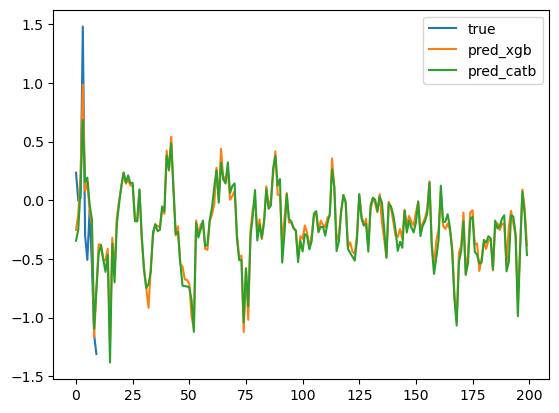

In [46]:
plt.plot(y_val[:10])
plt.plot(pred_xgb)
plt.plot(pred_catb)
plt.legend(["true", "pred_xgb", "pred_catb"])
plt.show()